#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/wbc.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,10.435952,10.435952,10.435952,10.435952,3.437588,0.0
1,4/01/2000,10.448864,10.448864,10.240284,10.240284,3.373133,2324971.0
2,5/01/2000,10.063487,10.081366,10.001907,10.051568,3.310971,2456811.0
3,6/01/2000,10.081366,10.111163,9.942312,10.031704,3.304429,4354261.0
4,7/01/2000,10.031704,10.061501,9.982042,10.031704,3.304429,2360114.0


<AxesSubplot:>

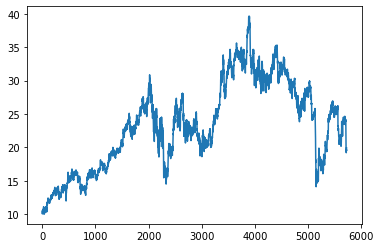

In [3]:
df["Close"].plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5692 entries, 0 to 5724
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5692 non-null   object 
 1   Open       5692 non-null   float64
 2   High       5692 non-null   float64
 3   Low        5692 non-null   float64
 4   Close      5692 non-null   float64
 5   Adj Close  5692 non-null   float64
 6   Volume     5692 non-null   float64
dtypes: float64(6), object(1)
memory usage: 355.8+ KB


In [5]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5692, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [6]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4554, 1)

In [7]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01366231, 0.00704935, 0.00067134, 0.        , 0.        ,
       0.00359179, 0.00386034, 0.00402818, 0.00704935, 0.01208457,
       0.02181938, 0.02249075, 0.01812687, 0.01879824, 0.01376299,
       0.01342732, 0.01208457, 0.01208457, 0.01715339, 0.0234978 ,
       0.01819402, 0.01376299, 0.01678415, 0.02282646, 0.02205437,
       0.02551192, 0.02745885, 0.03625377, 0.03289693, 0.02181938,
       0.01913391, 0.01544141, 0.01074185, 0.00268546, 0.        ,
       0.00167842, 0.        , 0.00268546, 0.00201409, 0.01342732,
       0.00201409, 0.01007048, 0.02239004, 0.01611278, 0.01040615,
       0.01040615, 0.01054042, 0.01342732, 0.0234978 , 0.02685463,
       0.02282646, 0.02249075, 0.02685463, 0.02886872, 0.02685463,
       0.0177912 , 0.01443436, 0.01611278, 0.00738502, 0.01510574])]
[0.010775413823760738]


# Prepare train data for LSTM model

In [8]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4494, 60)

In [9]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4494, 60, 1)

# Build the LSTM model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4494/4494 [==============================] - 66s 14ms/step - loss: 0.0010


In [13]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [14]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [15]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [16]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.10867225114701043

C:\Users\antoi\AppData\Local\Temp/ipykernel_7796/1869826583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


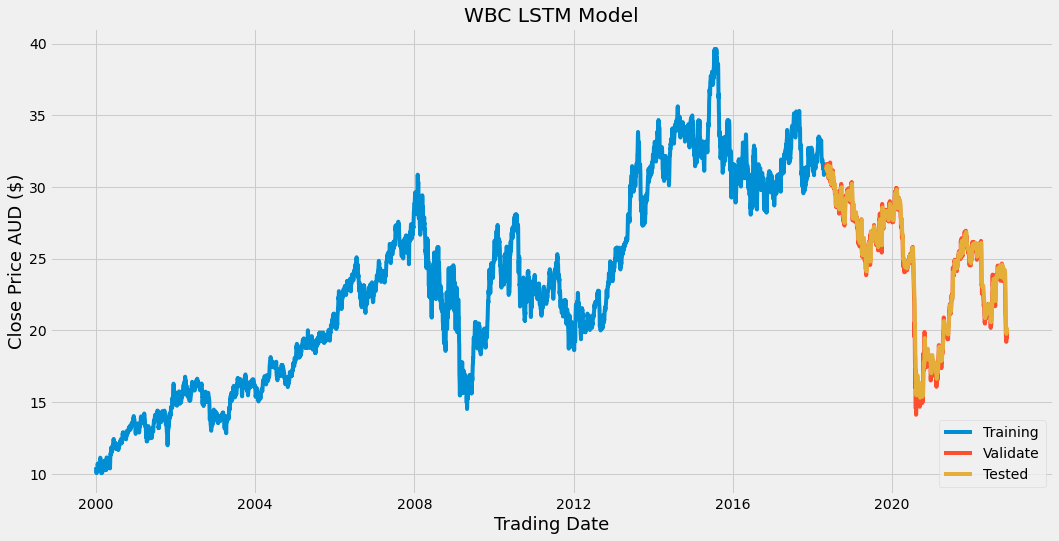

In [17]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('WBC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/wbc_graph.png')
plt.show()


# Test data Predictions on the Model

In [18]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_7796/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4587,31.389999,31.180557,0.209442
4588,31.549999,31.235392,0.314607
4589,31.350000,31.369041,-0.019041
4590,31.250000,31.354057,-0.104057
4591,31.230000,31.265352,-0.035352
...,...,...,...
5720,19.709999,19.745501,-0.035502
5721,19.530001,19.926067,-0.396066
5722,19.620001,20.031544,-0.411543
5723,19.480000,20.099159,-0.619159


In [ ]:
# Scraping latest prices:
#stock_quote_acual = web.DataReader('WBC.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv...

In [19]:
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB
db.wbc.drop()

import csv
header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
csvfile = open('../static/data/wbc.csv', 'r')
reader = csv.DictReader( csvfile )

for each in reader:
    row={}
    for field in header:
        row[field]=each[field]
        
    print (row)
    db.wbc.insert_one(row)		

{'Date': '3/01/2000', 'Open': '10.435952', 'High': '10.435952', 'Low': '10.435952', 'Close': '10.435952', 'Adj Close': '3.437588', 'Volume': '0', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '4/01/2000', 'Open': '10.448864', 'High': '10.448864', 'Low': '10.240284', 'Close': '10.240284', 'Adj Close': '3.373133', 'Volume': '2324971', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '5/01/2000', 'Open': '10.063487', 'High': '10.081366', 'Low': '10.001907', 'Close': '10.051568', 'Adj Close': '3.310971', 'Volume': '2456811', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '6/01/2000', 'Open': '10.081366', 'High': '10.111163', 'Low': '9.942312', 'Close': '10.031704', 'Adj Close': '3.304429', 'Volume': '4354261', 'SENTIMENT': 'NEUTRAL', 'RBA': '5', 'FED': '5.5'}
{'Date': '7/01/2000', 'Open': '10.031704', 'High': '10.061501', 'Low': '9.982042', 'Close': '10.031704', 'Adj Close': '3.304429', 'Volume': '2360114', 'SENTIMENT': 'POSITIVE', 'RBA': '5', 'FED': '

In [20]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'WBC.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [21]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days.shape

(60, 1)

In [22]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [23]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 20


In [24]:

stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5725,28/06/2022,19.959999,19.959999,19.620001,19.75,19.75,8230601.0,NEGATIVE,0.85,1.75


In [25]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date


'28/06/2022'

# Save the Model

In [26]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wbc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wbc_sixty and load df

In [27]:
# Read in the CSV file
# df_wbc_sixty = pd.read_csv("../static/data/wbc_sixty.csv")
# df_wbc_sixty.head()
wbcdump_sixty = pd.read_csv("../static/data/wbc.csv")
wbcdump_sixty = wbcdump_sixty.dropna()
wbcdump_sixty = wbcdump_sixty.iloc[-4250:]
sixty_val = wbcdump_sixty.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

In [28]:
# close_sixty_val = df_wbc_sixty[-60:].values
# last_sixty = close_sixty_val.reshape(-1,1)
# last_sixty.shape

In [29]:
last_sixty_scaled = scaler.transform(last_sixty)
new_X_tell = []
new_X_tell.append(last_sixty_scaled)
new_X_tell =np.array(new_X_tell)
new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
new_X_tell.shape

(1, 60, 1)

#PREDICT USING LOADED MODEL

In [30]:
from keras.models import load_model

In [31]:
model_in = load_model('../static/wbc_model.sav')

In [32]:
model_in_pd_scale = model_in.predict(new_X_tell)
model_in_pd_scale

array([[0.3422996]], dtype=float32)

In [33]:
model_in_price = scaler.inverse_transform(model_in_pd_scale)
#model_in_price_int = int(model_in_price)
print(f'Predicted next day share price {model_in_price}')

Predicted next day share price [[20.159859]]


#Create a function to loop through the days input

In [34]:
from keras.models import load_model
model_in = load_model('../static/wbc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Read in the CSV file

wbcdump_sixty = pd.read_csv("../static/data/wbc.csv")
wbcdump_sixty = wbcdump_sixty.dropna()
wbcdump_sixty = wbcdump_sixty.iloc[-4250:]
sixty_val = wbcdump_sixty.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 100 #days
if input == "":
    input = 100
else:
   input = int(input)

def predict_wbc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [35]:
predict_wbc(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

In [36]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,29/06/2022,Wednesday
1,2,30/06/2022,Thursday
2,3,1/07/2022,Friday
3,4,2/07/2022,Monday
4,5,3/07/2022,Tuesday
...,...,...,...
377,0,11/07/2023,Friday
378,0,12/07/2023,Monday
379,0,13/07/2023,Tuesday
380,0,14/07/2023,Wednesday


In [37]:
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_7796/2919172947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1, 'Date': '29/06/2022', 'DOW': 'Wednesday', 'Price': 20.01},
 {'Count': 2, 'Date': '30/06/2022', 'DOW': 'Thursday', 'Price': 20.08},
 {'Count': 3, 'Date': '1/07/2022', 'DOW': 'Friday', 'Price': 20.15},
 {'Count': 4, 'Date': '2/07/2022', 'DOW': 'Monday', 'Price': 20.21},
 {'Count': 5, 'Date': '3/07/2022', 'DOW': 'Tuesday', 'Price': 20.26},
 {'Count': 6, 'Date': '4/07/2022', 'DOW': 'Wednesday', 'Price': 20.29},
 {'Count': 7, 'Date': '5/07/2022', 'DOW': 'Thursday', 'Price': 20.32},
 {'Count': 8, 'Date': '6/07/2022', 'DOW': 'Friday', 'Price': 20.33},
 {'Count': 9, 'Date': '7/07/2022', 'DOW': 'Monday', 'Price': 20.34},
 {'Count': 10, 'Date': '8/07/2022', 'DOW': 'Tuesday', 'Price': 20.35},
 {'Count': 11, 'Date': '9/07/2022', 'DOW': 'Wednesday', 'Price': 20.35},
 {'Count': 12, 'Date': '10/07/2022', 'DOW': 'Thursday', 'Price': 20.36},
 {'Count': 13, 'Date': '11/07/2022', 'DOW': 'Friday', 'Price': 20.37},
 {'Count': 14, 'Date': '12/07/2022', 'DOW': 'Monday', 'Price': 20.37},
 {'Coun

In [38]:
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 20.01},
 {'Price': 20.08},
 {'Price': 20.15},
 {'Price': 20.21},
 {'Price': 20.26},
 {'Price': 20.29},
 {'Price': 20.32},
 {'Price': 20.33},
 {'Price': 20.34},
 {'Price': 20.35},
 {'Price': 20.35},
 {'Price': 20.36},
 {'Price': 20.37},
 {'Price': 20.37},
 {'Price': 20.38},
 {'Price': 20.39},
 {'Price': 20.41},
 {'Price': 20.42},
 {'Price': 20.43},
 {'Price': 20.45},
 {'Price': 20.46},
 {'Price': 20.48},
 {'Price': 20.5},
 {'Price': 20.51},
 {'Price': 20.53},
 {'Price': 20.54},
 {'Price': 20.56},
 {'Price': 20.57},
 {'Price': 20.58},
 {'Price': 20.6},
 {'Price': 20.61},
 {'Price': 20.62},
 {'Price': 20.63},
 {'Price': 20.64},
 {'Price': 20.66},
 {'Price': 20.67},
 {'Price': 20.68},
 {'Price': 20.69},
 {'Price': 20.7},
 {'Price': 20.71},
 {'Price': 20.72},
 {'Price': 20.73},
 {'Price': 20.74},
 {'Price': 20.75},
 {'Price': 20.76},
 {'Price': 20.77},
 {'Price': 20.76},
 {'Price': 20.74},
 {'Price': 20.72},
 {'Price': 20.7},
 {'Price': 20.68},
 {'Price': 20.66},
 {'Price': 20.65

In [39]:
# DRAW THE PREDICTION
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4554 5692 5792


,Close
5781,20.64
5782,20.64
5783,20.64
5784,20.64
5785,20.64
5786,20.64
5787,20.64
5788,20.64
5789,20.64
5790,20.64


C:\Users\antoi\AppData\Local\Temp/ipykernel_7796/972127207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


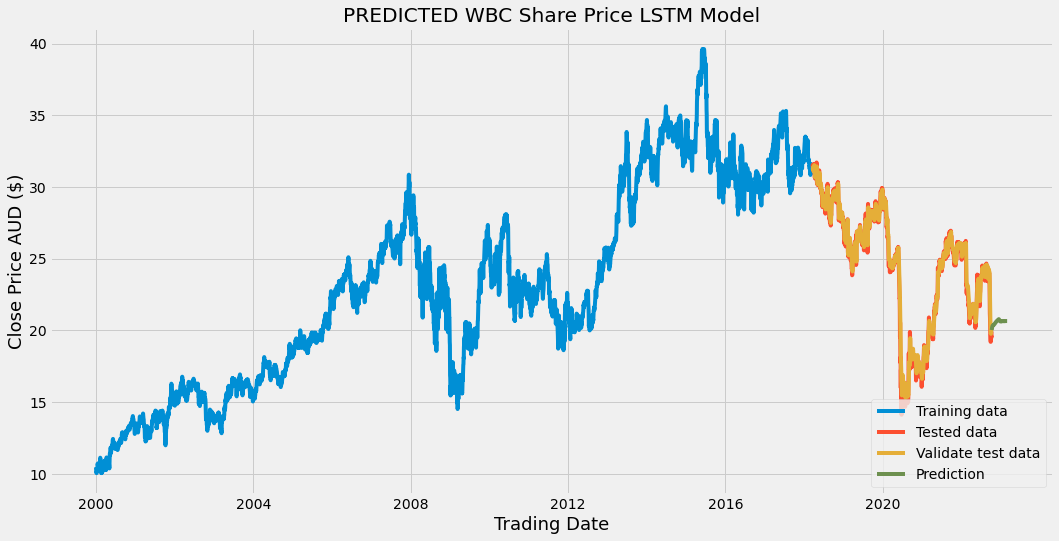

In [40]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTED WBC Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/wbc_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [41]:
# Module used to connect Python with MongoDb
import pymongo

In [42]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

In [43]:
# Query all
companys = db.find()
# Iterate through each company in the collection
for company in companys:
    print(company)

# Here, db.companys refers to the collection 'companys '
# company_nab = db.find_one({'name': 'NAB'})
# print(company_nab)


{'_id': ObjectId('62bbca7acc73d07c34c73fbb'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 19, 'actual': 19, 'differece': 0, 'rmse': 0.15231}
{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 97.51}
{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74a49c5dda6983912be2'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.16

In [44]:
# Delete a document from a collection
db.delete_one(
    {'name': 'WBC'}
)

# query the companys collection
companys = db.find()
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 97.51}
{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74a49c5dda6983912be2'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.16451}


In [45]:
# Set keys and values of company
name = 'WBC'
predicted = int(pred_price)
difference = pred_price-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}, rmse {round(rmse,5)}')

date 28/06/2022,predicted 20,actual 19, difference 1, rmse 0.10867


In [46]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference,
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 97.51}
{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74a49c5dda6983912be2'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.16451}
{'_id': ObjectId('62be74fb286df5ebd4ec3dc5'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 20, 'actual': 19, 'differece': 1, 'rmse': 0.10

In [48]:
# # query the collection
# wbcs = db.wbc.find()

# # see change in collection
# for wbc in wbcs:
#     print(wbc)